In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [2]:
# 📒 train_eval.ipynb (cell-by-cell)

# 1️⃣ Import Libraries
import os
import zipfile
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

2025-07-30 15:43:13.766660: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-30 15:43:13.807178: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-30 15:43:14.991231: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# 2️⃣ Unzip Dataset

zip_path = "/home/user/Downloads/leaf_dataset_small.zip"  # adjust path if needed
extract_path = "../data/processed/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset extracted!")


✅ Dataset extracted!


In [4]:
# 3️⃣ Filter Only 3 Classes

all_classes = ['Tomato___Bacterial_spot', 'Tomato___Late_blight', 'Tomato___Healthy']
base_input_path = os.path.join(extract_path, "leaf_dataset_small")  # Adjust if structure is different
filtered_path = "../data/processed/filtered_classes/"

if not os.path.exists(filtered_path):
    os.makedirs(filtered_path)
    for cls in all_classes:
        src = os.path.join(base_input_path, cls)
        dst = os.path.join(filtered_path, cls)
        shutil.copytree(src, dst)
print("✅ 3 tomato classes filtered.")


✅ 3 tomato classes filtered.


In [5]:
# 4️⃣ Split into Train, Val, Test

def split_data(input_dir, output_dir, split_ratios=(0.7, 0.2, 0.1), seed=42):
    random.seed(seed)
    for cls in os.listdir(input_dir):
        cls_path = os.path.join(input_dir, cls)
        imgs = os.listdir(cls_path)
        random.shuffle(imgs)
        
        total = len(imgs)
        train_end = int(split_ratios[0]*total)
        val_end = train_end + int(split_ratios[1]*total)
        
        splits = {
            'train': imgs[:train_end],
            'val': imgs[train_end:val_end],
            'test': imgs[val_end:]
        }
        
        for split in splits:
            split_cls_dir = os.path.join(output_dir, split, cls)
            os.makedirs(split_cls_dir, exist_ok=True)
            for img in splits[split]:
                shutil.copy(os.path.join(cls_path, img), os.path.join(split_cls_dir, img))

split_data(filtered_path, "../data/processed/content/drive/MyDrive/leaf_dataset_small/")
print("✅ Train/Val/Test split complete.")


✅ Train/Val/Test split complete.


In [6]:
# 5️⃣ Prepare Data Generators

data_path = "../data/processed/content/drive/MyDrive/leaf_dataset_small/"
batch_size = 32
img_size = (128, 128)

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True)
val_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_directory(os.path.join(data_path, 'train'), target_size=img_size, class_mode='categorical', batch_size=batch_size)
val_ds = val_gen.flow_from_directory(os.path.join(data_path, 'val'), target_size=img_size, class_mode='categorical', batch_size=batch_size)
test_ds = val_gen.flow_from_directory(os.path.join(data_path, 'test'), target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False)

print("✅ Data generators ready.")


Found 805 images belonging to 3 classes.
Found 238 images belonging to 3 classes.
Found 119 images belonging to 3 classes.
✅ Data generators ready.


In [7]:
# 6️⃣ Build Model

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/home/user/miniconda3/envs/jupyter_gpu_env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 7️⃣ Callbacks & Training

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("../outputs/model.h5", save_best_only=True),
    ReduceLROnPlateau(patience=3, factor=0.2)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)


/home/user/miniconda3/envs/jupyter_gpu_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2923 - loss: 1.1189

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - accuracy: 0.2951 - loss: 1.1176 - val_accuracy: 0.6429 - val_loss: 0.9587 - learning_rate: 0.0010
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.6072 - loss: 0.9013

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.6081 - loss: 0.8999 - val_accuracy: 0.8025 - val_loss: 0.6661 - learning_rate: 0.0010
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7779 - loss: 0.6576

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.7779 - loss: 0.6560 - val_accuracy: 0.7689 - val_loss: 0.5458 - learning_rate: 0.0010
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7595 - loss: 0.5753

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.7610 - loss: 0.5728 - val_accuracy: 0.8109 - val_loss: 0.4311 - learning_rate: 0.0010
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7951 - loss: 0.4778

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.7947 - loss: 0.4792 - val_accuracy: 0.8277 - val_loss: 0.3645 - learning_rate: 0.0010
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8302 - loss: 0.4266

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 0.8300 - loss: 0.4273 - val_accuracy: 0.8403 - val_loss: 0.3355 - learning_rate: 0.0010
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8466 - loss: 0.3587

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.8465 - loss: 0.3591 - val_accuracy: 0.8529 - val_loss: 0.2795 - learning_rate: 0.0010
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.8289 - loss: 0.3929 - val_accuracy: 0.8487 - val_loss: 0.3315 - learning_rate: 0.0010
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.7902 - loss: 0.4296

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.7920 - loss: 0.4271 - val_accuracy: 0.8613 - val_loss: 0.2679 - learning_rate: 0.0010
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8869 - loss: 0.2640

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.8862 - loss: 0.2651 - val_accuracy: 0.8866 - val_loss: 0.2373 - learning_rate: 0.0010
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8797 - loss: 0.2867 - val_accuracy: 0.8866 - val_loss: 0.2416 - learning_rate: 0.0010
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.8530 - loss: 0.3447

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 0.8539 - loss: 0.3433 - val_accuracy: 0.8782 - val_loss: 0.2347 - learning_rate: 0.0010
Epoch 13/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.8803 - loss: 0.2717 - val_accuracy: 0.6429 - val_loss: 1.3425 - learning_rate: 0.0010
Epoch 14/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.8031 - loss: 0.7096 - val_accuracy: 0.8655 - val_loss: 0.3362 - learning_rate: 0.0010
Epoch 15/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 0.8584 - loss: 0.3539 - val_accuracy: 0.8782 - val_loss: 0.2591 - learning_rate: 0.0010
Epoch 16/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9147 - loss: 0.2283

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.9146 - loss: 0.2285 - val_accuracy: 0.8908 - val_loss: 0.2199 - learning_rate: 2.0000e-04
Epoch 17/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9025 - loss: 0.2318

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.9028 - loss: 0.2310 - val_accuracy: 0.8950 - val_loss: 0.2198 - learning_rate: 2.0000e-04
Epoch 18/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9106 - loss: 0.1982 - val_accuracy: 0.8782 - val_loss: 0.2578 - learning_rate: 2.0000e-04
Epoch 19/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9184 - loss: 0.2021 - val_accuracy: 0.8992 - val_loss: 0.2355 - learning_rate: 2.0000e-04
Epoch 20/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9185 - loss: 0.2124 - val_accuracy: 0.9076 - val_loss: 0.2259 - learning_rate: 4.0000e-05


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
                     precision    recall  f1-score   support

Tomato_Early_blight       0.80      0.85      0.82        39
     Tomato_Healthy       0.98      1.00      0.99        40
 Tomato_Late_blight       0.84      0.78      0.81        40

           accuracy                           0.87       119
          macro avg       0.87      0.87      0.87       119
       weighted avg       0.87      0.87      0.87       119



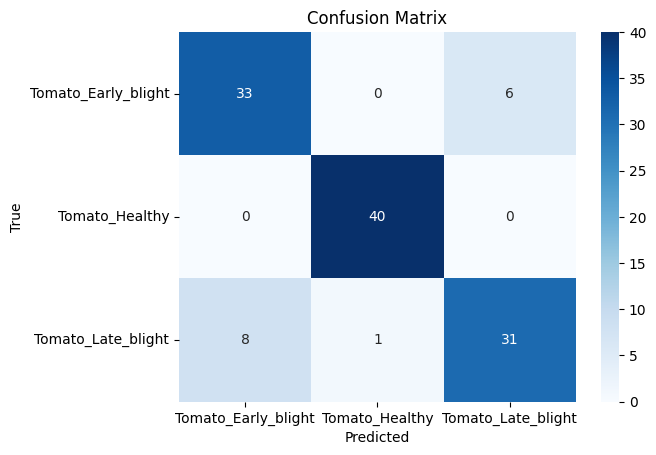

In [9]:
# 8️⃣ Evaluation on Test Set

test_preds = model.predict(test_ds)
y_pred = np.argmax(test_preds, axis=1)
y_true = test_ds.classes
labels = list(test_ds.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [10]:
# 9️⃣ Save Sample Predictions

import cv2

pred_dir = "../outputs/predictions/"
os.makedirs(pred_dir, exist_ok=True)

for i in range(10):
    img_path = test_ds.filepaths[i]
    img = cv2.imread(img_path)
    label = labels[y_pred[i]]
    cv2.imwrite(os.path.join(pred_dir, f"{label}_{i}.jpg"), img)
print("✅ Sample predictions saved.")


✅ Sample predictions saved.


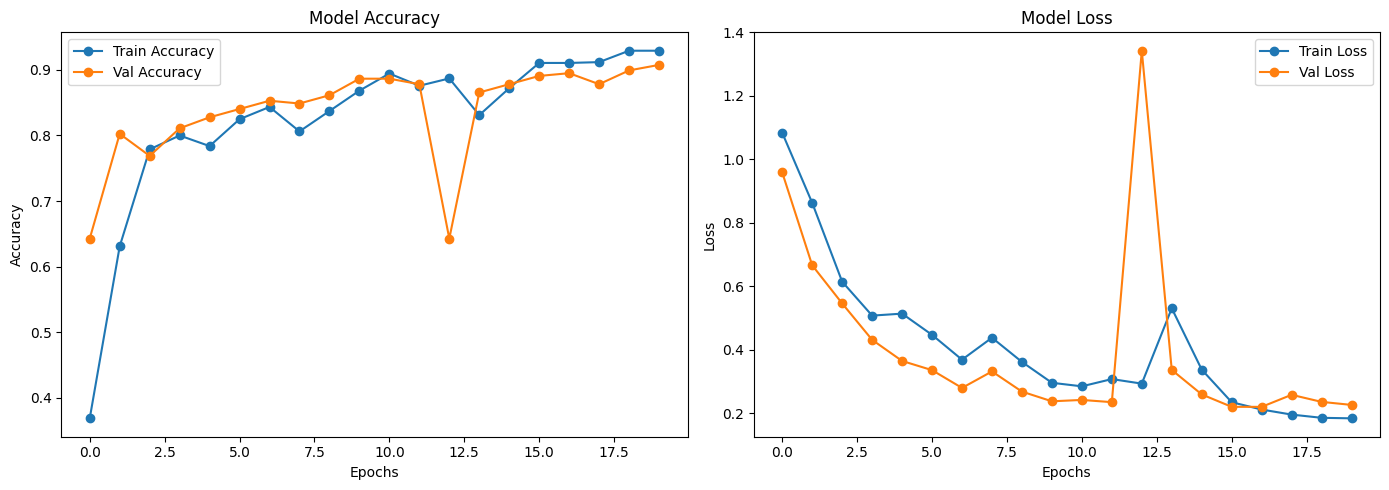

Macro F1-Score on Test Set: 0.8726


In [11]:
# 🔢 Accuracy, Loss & F1 Score Plots + Calculation
from sklearn.metrics import f1_score

# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# F1-Score (Macro)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"Macro F1-Score on Test Set: {f1:.4f}")


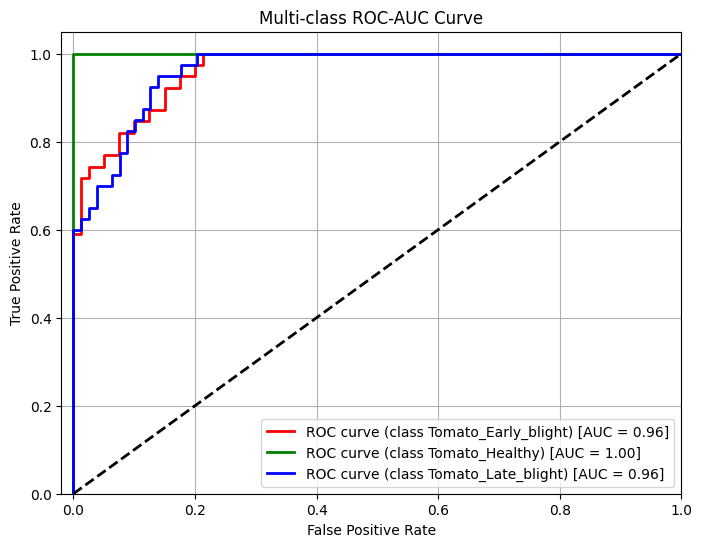

In [12]:
# 🧪 Multi-class ROC AUC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize labels for 3-class ROC AUC
y_true_bin = label_binarize(y_true, classes=[0,1,2])
n_classes = y_true_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], test_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {labels[i]}) [AUC = {roc_auc[i]:.2f}]')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC-AUC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss

# Accuracy
acc = accuracy_score(y_true, y_pred)

# Categorical cross-entropy loss (same as used in model.compile)
loss = log_loss(y_true, test_preds)

# F1 Scores
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

# Precision
precision_macro = precision_score(y_true, y_pred, average='macro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

# Recall
recall_macro = recall_score(y_true, y_pred, average='macro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

# 📢 Print all results nicely
print("🔍 Evaluation Metrics on Test Set")
print(f"✅ Accuracy        : {acc:.4f}")
print(f"🔻 Loss (LogLoss)  : {loss:.4f}")
print(f"🎯 F1 Score (Macro): {f1_macro:.4f}")
print(f"🎯 F1 Score (Wtd)  : {f1_weighted:.4f}")
print(f"🎯 Precision (Macro): {precision_macro:.4f}")
print(f"🎯 Precision (Wtd)  : {precision_weighted:.4f}")
print(f"🎯 Recall (Macro)   : {recall_macro:.4f}")
print(f"🎯 Recall (Wtd)     : {recall_weighted:.4f}")


🔍 Evaluation Metrics on Test Set
✅ Accuracy        : 0.8739
🔻 Loss (LogLoss)  : 0.2374
🎯 F1 Score (Macro): 0.8726
🎯 F1 Score (Wtd)  : 0.8730
🎯 Precision (Macro): 0.8728
🎯 Precision (Wtd)  : 0.8733
🎯 Recall (Macro)   : 0.8737
🎯 Recall (Wtd)     : 0.8739
